In [1]:
import csv
import numpy as np
import pandas as pd
from tabulate import tabulate
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt
%cd /storage2/mwildi/CBS2

/storage2/mwildi/CBS2


In [2]:
#Plots data inside data_per_model
def plotter(data_per_model, main_title, legends, x_ticks, x_description, y_description, savepath):
    assert(len(legends)==data_per_model.shape[0])
    assert(len(x_ticks)==data_per_model.shape[1])

    metrics = pd.DataFrame(np.array([data_per_model[:,i] for i in range(len(x_ticks))]), columns=legends)
    ax = metrics.plot(kind='bar', figsize=(12, 7), legend=True, fontsize=16)
    ax.set_xlabel(x_description)
    x = np.arange(len(x_ticks))
    ax.set_xticks(x)
    ax.set_xticklabels(x_ticks, fontsize=16, rotation='horizontal')
    ax.set_ylabel(y_description, fontsize=16)
    plt.title(main_title, fontsize=20, weight='bold')
    plt.savefig(savepath)

In [3]:
#####################################################################################
# Parsing code adapted from World on Rails scripts/view_nocrash_results
#####################################################################################

def parse_results(path):
    
    TOWNS = ['Town01', 'Town02']
    TRAFFICS = ['empty', 'regular', 'dense']
    WEATHERS = {
        1: 'train', 3: 'train', 6: 'train', 8: 'train',
        10: 'test', 14: 'test',
    }
    #METRICS = ['sr', 'rc', 'l', 'nb', 'nc', 'ncv', 'ncw', 'rcwc']
    METRICS = ['Success Rate', 'Route Completion', 'Lights Ran ph', 'No Block', 'No Collision', 'No Collision Veh', 'No Collision Walk', 'RC When Collided']

    finished = defaultdict(lambda: [])

    with open(path+'.csv', 'r') as file:
        log = csv.DictReader(file)
        for row in log:
            finished[(
                row['town'],
                int(row['traffic']),
                WEATHERS[int(row['weather'])],
            )].append((
                float(row['route_completion']),
                int(row['lights_ran']),
                float(row['duration']),
                float(row['outside_lane']),
                str(row['collision']),
                str(row['collision_vehicle']),
                str(row['collision_walker']),
                str(row['in_route']),
                str(row['blocked'])
            ))

    all_stats=dict()
    
    for town, weather_set in product(TOWNS, set(WEATHERS.values())):

        all_stats[town+weather_set] = {}
        
        for metric in METRICS:
            stat= ['N/A']*len(TRAFFICS)

            for traffic_idx, traffic in enumerate(TRAFFICS):
                runs = finished[town,TRAFFICS.index(traffic),weather_set]

                if len(runs) > 0:
                    route_completion, lights_ran, duration, outside_lane, collision, collision_vehicle, collision_walker, in_route, blocked = zip(*runs)
                    mean_lights_ran = np.array(lights_ran)/np.array(duration)*3600

                    if metric == 'Success Rate': # Success Rate
                        stat[traffic_idx] = np.round(100*np.mean(np.array(route_completion)==100), 2)
                    elif metric == 'Route Completion': # Route Completion
                        stat[traffic_idx] = np.round(np.mean(route_completion), 2)
                    elif metric == 'Lights Ran ph': # Lights Ran per hour
                        stat[traffic_idx] = np.round(np.mean(mean_lights_ran), 2)
                    elif metric == 'No Block': # No block
                        stat[traffic_idx] = np.round(100*blocked.count('SUCCESS')/len(blocked), 2)
                    elif metric == 'No Collision': # No Collision
                        stat[traffic_idx] = round(100*collision.count('SUCCESS')/len(collision), 2)
                    elif metric == 'No Collision Veh': # No Collision vehicle
                        stat[traffic_idx] = np.round(100*collision_vehicle.count('SUCCESS')/len(collision_vehicle), 2)
                    elif metric == 'No Collision Walk': # No Collision walker
                        stat[traffic_idx] = np.round(100*collision_walker.count('SUCCESS')/len(collision_walker), 2)
                    elif metric == 'RC When Collided': # Route completion when collided
                        collided = [True if x=='FAILURE' else False for x in collision]
                        stat[traffic_idx] = np.round(np.mean(np.array(route_completion)[collided]), 2)

                all_stats[town+weather_set][metric] = stat
                
    return all_stats

In [4]:
original=parse_results('results/final/nc_original')
ppm=parse_results('results/final/nc_ppm')
fpn=parse_results('results/final/nc_ppm')

In [5]:
ppm

{'Town01test': {'Success Rate': [32.0, 30.0, 4.0],
  'Route Completion': [57.56, 62.4, 35.4],
  'Lights Ran ph': [37.0, 41.1, 46.03],
  'No Block': [58.0, 76.0, 90.0],
  'No Collision': [74.0, 56.0, 14.0],
  'No Collision Veh': [100.0, 86.0, 36.0],
  'No Collision Walk': [100.0, 98.0, 98.0],
  'RC When Collided': [51.52, 55.47, 34.04]},
 'Town01train': {'Success Rate': [31.0, 28.0, 5.0],
  'Route Completion': [54.56, 56.3, 39.19],
  'Lights Ran ph': [29.49, 32.86, 35.43],
  'No Block': [60.0, 79.0, 93.0],
  'No Collision': [76.0, 55.0, 18.0],
  'No Collision Veh': [100.0, 87.0, 39.0],
  'No Collision Walk': [100.0, 99.0, 96.0],
  'RC When Collided': [35.9, 42.44, 34.88]},
 'Town02test': {'Success Rate': [22.0, 20.0, 6.0],
  'Route Completion': [46.8, 49.29, 39.53],
  'Lights Ran ph': [43.78, 46.34, 52.47],
  'No Block': [62.0, 80.0, 92.0],
  'No Collision': [82.0, 64.0, 32.0],
  'No Collision Veh': [100.0, 88.0, 58.0],
  'No Collision Walk': [100.0, 100.0, 98.0],
  'RC When Collided': 

In [9]:
#['Success Rate', 'Route Completion', 'Lights Ran ph', 'No Block', 'No Collision', 'No Collision Veh', 'No Collision Walk', 'RC When Collided']
main_title = 'Directional command at intersection'
y_description = '[%] of dataset intersection frames'
savepath = 'Notebooks/plots/dataset/dataset_cmd.png'

plot_traffic=None
plot_config='Town02test'
plot_metric='Lights Ran ph'

In [10]:
legends = ['Original', 'PPM', 'FPN']
#Comparison according to traffic
if plot_traffic == None:
    x_ticks = ['Empty', 'Regular', 'Dense']
    x_description = 'Traffic condition (in '+plot_config+')'
    data_original = original[plot_config][plot_metric]
    data_ppm = ppm[plot_config][plot_metric]
    data_fpn = fpn[plot_config][plot_metric]
#Comparison according to train/test
else:
    configs = ['Town01train', 'Town02test']
    traffics= ['empty', 'regular', 'dense']
    x_ticks = ['Train', 'Test']
    x_description = 'Town and weather configuration (in '+plot_traffic+')'
    data_original = [original[config][plot_metric][traffics.index(plot_traffic)] for config in configs]
    data_ppm = [ppm[config][plot_metric][traffics.index(plot_traffic)] for config in configs]
    data_fpn = [fpn[config][plot_metric][traffics.index(plot_traffic)] for config in configs]  

data_per_model = np.vstack((data_original, data_ppm, data_fpn))
print(data_per_model)

[[42.61 67.03 66.4 ]
 [43.78 46.34 52.47]
 [43.78 46.34 52.47]]


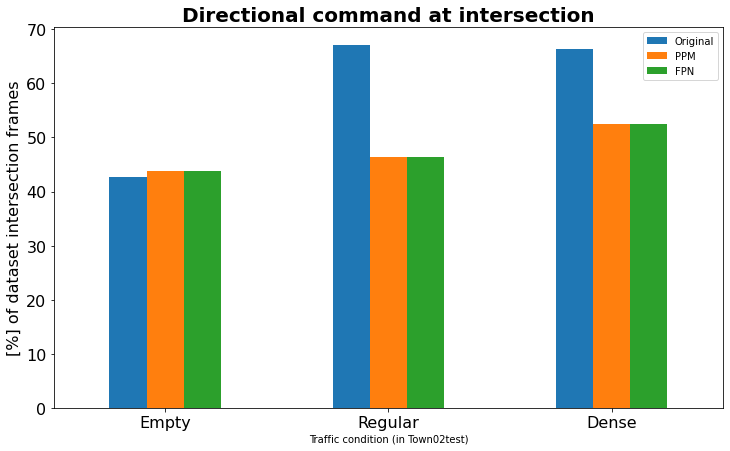

In [11]:
plotter(data_per_model, main_title, legends, x_ticks, x_description, y_description, savepath)